# Students IDs: 211896261 322593070 322642752
### Notebook runned in the Google Colab environment, no special installations needed, only uploading the csvs to the sample_data folder.

# Question 1:

In [32]:
import pandas as pd

def Load(filename: str, year: int):
  return pd.read_csv(filename).query('Year == @year').to_dict('records')


# Question 2:

In [33]:
# def Split_Train_Test(filename):
#     df = pd.read_csv(filename)
#     years = sorted(df['Year'].astype(int).unique())
#     # assuming there are 3 years
#     train_years = years[:-1]
#     test_year = years[-1]
#     train_data = df[df['Year'].astype(int).isin(train_years)]
#     test_data = df[df['Year'].astype(int) == test_year]
#     return train_data, test_data

def Split_Train_Test(filename):
    df = pd.read_csv(filename)
    df['Year'] = df['Year'].astype(int)
    years = sorted(df['Year'].unique())
    train_years = [y for i, y in enumerate(years) if i % 3 != 2]
    test_years = [y for i, y in enumerate(years) if i % 3 == 2]
    return df[df['Year'].isin(train_years)], df[df['Year'].isin(test_years)]


# Question 3:

In [34]:
def RMSE(y_true, y_pred):
    return (sum((float(a) - float(b)) ** 2 for a, b in zip(y_true, y_pred)) / len(y_true)) ** 0.5

### **We chose MAE because it is less sensitive to anomalies, so it completes RMSE.**

In [35]:
def MAE(y_true, y_pred):
  return sum(abs(float(a) - float(b)) for a, b in zip(y_true, y_pred)) / len(y_true)

# Question 4:

In [36]:
import random

def TrainBaseModel(train_data, K=10, gamma=0.05, lambd=0.05, max_epochs=50, validation_ratio=0.2, seed=42):
    # train and validation split
    train = train_data.sample(frac=1-validation_ratio, random_state=seed)
    validation = train_data.drop(train.index.tolist())

    # calculation of mu average
    mu = train['stars'].astype(float).mean()

    # random parameters
    users = set(train['user_id'].unique())
    items = set(train['business_id'].unique())
    bu = {u: 0.0 for u in users}
    bi = {i: 0.0 for i in items}
    pu = {u: [random.uniform(-0.01, 0.01) for _ in range(K)] for u in users}
    qi = {i: [random.uniform(-0.01, 0.01) for _ in range(K)] for i in items}

    # model training
    prev_val_rmse = float('inf')
    for epoch in range(max_epochs):
      # shuffle the training data for each epoch
        train_shuffled = train.sample(frac=1, random_state=epoch)
        for index, row in train_shuffled.iterrows():
            u = row['user_id']
            i = row['business_id']
            r_ui = float(row['stars'])

            if u in pu and i in qi:
              pred = mu + bu[u] + bi[i] + sum(p * q for p, q in zip(pu[u], qi[i]))
              e_ui = r_ui - pred

              # update parameters
              bu[u] += gamma * (e_ui - lambd * bu[u])
              bi[i] += gamma * (e_ui - lambd * bi[i])
              for k in range(K):
                  pu[u][k] += gamma * (e_ui * qi[i][k] - lambd * pu[u][k])
                  qi[i][k] += gamma * (e_ui * pu[u][k] - lambd * qi[i][k])

        # RMSE calculation and early stop
        val_true = []
        val_pred = []
        for index, row in validation.iterrows():
            u = row['user_id']
            i = row['business_id']
            r_ui = float(row['stars'])
            if u not in pu or i not in qi:
                pred = mu
            else:
                pred = mu + bu.get(u, 0) + bi.get(i, 0) + sum(p * q for p, q in zip(pu[u], qi[i]))
            val_true.append(r_ui)
            val_pred.append(pred)
        val_rmse = RMSE(val_true, val_pred)
        print(f"Epoch {epoch+1}: Validation RMSE = {val_rmse:.4f}")

        if val_rmse > prev_val_rmse:
            print("early stop: RMSE validation worsen.")
            break
        prev_val_rmse = val_rmse

    return mu, bu, bi, pu, qi

# Question 5:

In [37]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(pu, qi, sample_size=1000):
    user_vecs = list(pu.values())[:sample_size]
    item_vecs = list(qi.values())[:sample_size]
    all_vecs = user_vecs + item_vecs
    labels = ['user']*len(user_vecs) + ['item']*len(item_vecs)

    all_vecs = np.array(all_vecs)

    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(all_vecs)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:len(user_vecs),0], reduced[:len(user_vecs),1], c='blue', label='users', alpha=0.5)
    plt.scatter(reduced[len(user_vecs):,0], reduced[len(user_vecs):,1], c='red', label='items', alpha=0.5)
    plt.legend()
    plt.title('t-SNE Visualization of User and Item Embeddings')
    plt.show()

### Insights from the graph:
1. Overlap Between User and Item Embeddings:
The plot shows that user embeddings (blue) and item embeddings (red) are distributed throughout the same two-dimensional space, with significant overlap between the two groups. This suggests that the model has learned to represent users and items in a shared latent space, where similar users and items are positioned closer together. Such overlap may indicate that the model is capturing shared patterns or preferences between users and items.

2. No Clear Clustering:
There are no distinct clusters or well-separated groups in the plot. Both users and items appear to be spread relatively evenly across the space. This lack of clear clustering could mean that the data does not contain strong subgroups of users or items, or that the model embeddings do not strongly differentiate between different types of users or items. Alternatively, it may be a result of dimensionality reduction via t-SNE, which sometimes obscures subtle structures present in higher dimensions.

3. Outlier Users and Items on the Edges:
At the edges of the plot, we observe isolated points. users or items with little connection to the center. These may represent users with very unique preferences or rare items that are not commonly interacted with.
This is important for identifying niche domains or unusual behavior.


# Question 6
### We implemented a content based model based on business categories, where each user is represented by a profile of their average ratings per category. We chose this model because it leverages available content information that was not used in previous models, and takes into account both the number and type of ratings a user has given. This allows for an accurate representation of user preferences and effective prediction for new businesses.

In [38]:
import pandas as pd
from collections import defaultdict

def TrainContentModel(train_data, business_filename):
    business_df = pd.read_csv(business_filename)
    business_categories = {}
    for idx, row in business_df.iterrows():
        bid = row['business_id']
        cats = set(str(row['categories']).split(';'))
        business_categories[bid] = cats

    user_cat_ratings = defaultdict(lambda: defaultdict(list))
    user_cat_counts = defaultdict(lambda: defaultdict(int))
    user_all_ratings = defaultdict(list)

    for index, row in train_data.iterrows():
        user = row['user_id']
        business = row['business_id']
        rating = float(row['stars'])
        user_all_ratings[user].append(rating)
        cats = business_categories.get(business, set())
        for cat in cats:
            user_cat_ratings[user][cat].append(rating)
            user_cat_counts[user][cat] += 1

    user_cat_profile = defaultdict(dict)
    for user in user_cat_ratings:
        for cat in user_cat_ratings[user]:
            total = sum(user_cat_ratings[user][cat])
            count = user_cat_counts[user][cat]
            user_cat_profile[user][cat] = (total, count)

    user_mean_rating = {
        user: sum(ratings) / len(ratings)
        for user, ratings in user_all_ratings.items()
    }

    return user_cat_profile, user_mean_rating, business_categories

# Question 7:

In [39]:
def PredictRating_MF(mu, bu, bi, pu, qi, user_id, business_id):
    if user_id not in pu or business_id not in qi:
        return mu
    pred = mu + bu.get(user_id, 0) + bi.get(business_id, 0) + sum(p*q for p, q in zip(pu[user_id], qi[business_id]))
    return pred

In [40]:
def PredictRating_Content(user_cat_profile, user_mean_rating, business_categories, user_id, business_id, global_mean=3.5):
    cats = business_categories.get(business_id, set())
    if not cats:
        return user_mean_rating.get(user_id, global_mean)

    total_weighted = 0
    total_count = 0
    for cat in cats:
        cat_data = user_cat_profile.get(user_id, {}).get(cat)
        if cat_data:
            total, count = cat_data
            total_weighted += total
            total_count += count

    if total_count > 0:
        return total_weighted / total_count
    return user_mean_rating.get(user_id, global_mean)


# Question 8:

Epoch 1: Validation RMSE = 1.2466
Epoch 2: Validation RMSE = 1.2325
Epoch 3: Validation RMSE = 1.2297
Epoch 4: Validation RMSE = 1.2314
early stop: RMSE validation worsen.


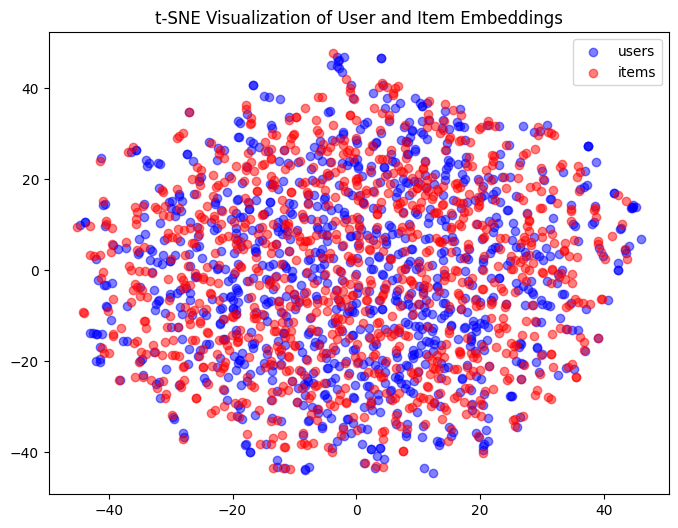

In [41]:
train_data, test_data = Split_Train_Test("sample_data/Yelp_ratings.csv")
mu, bu, bi, pu, qi = TrainBaseModel(train_data, K=10, gamma=0.05, lambd=0.05, max_epochs=50)
visualize_embeddings(pu,qi)
user_cat_profile, user_mean_rating, business_categories = TrainContentModel(train_data, 'sample_data/yelp_business.csv')

In [43]:
y_true = [float(row['stars']) for index, row in test_data.iterrows()]
y_pred_mf = [PredictRating_MF(mu, bu, bi, pu, qi, row['user_id'], row['business_id']) for index, row in test_data.iterrows()]
y_pred_content = [PredictRating_Content(user_cat_profile, user_mean_rating, business_categories, row['user_id'], row['business_id']) for index, row in test_data.iterrows()]

print("MF RMSE:", RMSE(y_true, y_pred_mf))
print("MF MAE:", MAE(y_true, y_pred_mf))
print("Content RMSE:", RMSE(y_true, y_pred_content))
print("Content MAE:", MAE(y_true, y_pred_content))

MF RMSE: 1.2806404501496034
MF MAE: 1.0368571495179033
Content RMSE: 1.4709850279964278
Content MAE: 1.1423475851317668


Results:
The Matrix Factorization model (MF) achieved better predictive accuracy than the content-based model. Specifically, MF obtained an RMSE of 1.2806 and an MAE of 1.0368, while the content-based model reached an RMSE of 1.4709 and an MAE of 1.1423. These metrics indicate that the MF model produced smaller prediction errors on average, both in terms of squared and absolute differences from the true ratings.


Conclusions:
While the Matrix Factorization model performs better overall, the content-based model still provides valuable insights and serves as an important complementary approach. It leverages business metadata (such as categories) that is not used in MF, and it remains effective in cold-start situations where little to no rating data exists for a user or business. Therefore, combining both models in a hybrid system could enhance robustness and improve recommendation quality in diverse scenarios.
